In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

randomeseed = 1640

## Load Data

In [2]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
rating_df = pd.read_csv(rating_url)
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


In [3]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


In [4]:
class RecommenderNet(keras.Model):
    
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        
        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")
        
        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")
        
    def call(self, inputs):
        """
           method to be called during model fitting
           
           :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Sigmoid output layer to output the probability
        return tf.nn.relu(x)

In [5]:
def process_dataset(raw_data):
    
    encoded_data = raw_data.copy()
    
    # Mapping user ids to indices
    user_list = encoded_data["user"].unique().tolist()
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)}
    
    # Mapping course ids to indices
    course_list = encoded_data["item"].unique().tolist()
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)}
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)}

    # Convert original user ids to idx
    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    # Convert original course ids to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    # Convert rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, course_idx2id_dict

In [6]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df)

In [7]:
encoded_data.head()

,user,item,rating
0,0,0,3
1,1,1,3
2,2,2,3
3,3,3,3
4,4,4,3


In [8]:
def generate_train_test_datasets(dataset, scale=True):

    min_rating = min(dataset["rating"])
    max_rating = max(dataset["rating"])

    dataset = dataset.sample(frac=1, random_state=42)
    x = dataset[["user", "item"]].values
    if scale:
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        y = dataset["rating"].values

    # Assuming training on 80% of the data and validating on 10%, and testing 10%
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])

    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices],
        x[train_indices:test_indices],
        x[test_indices:],
        y[:train_indices],
        y[train_indices:test_indices],
        y[test_indices:],
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

In [9]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

In [10]:
embedding_size = 16
model = RecommenderNet(num_users, num_items, embedding_size)

Training shape (186644, 2), (186644,)
Epoch 1/10
2917/2917 [==============================] - 20s 6ms/step - loss: 0.1343 - root_mean_squared_error: 0.3661 - val_loss: 0.0437 - val_root_mean_squared_error: 0.2078
Epoch 2/10
2917/2917 [==============================] - 18s 6ms/step - loss: 0.0413 - root_mean_squared_error: 0.2015 - val_loss: 0.0375 - val_root_mean_squared_error: 0.1916
Epoch 3/10
2917/2917 [==============================] - 19s 6ms/step - loss: 0.0284 - root_mean_squared_error: 0.1658 - val_loss: 0.0287 - val_root_mean_squared_error: 0.1664
Epoch 4/10
2917/2917 [==============================] - 19s 6ms/step - loss: 0.0219 - root_mean_squared_error: 0.1440 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1493
Epoch 5/10
2917/2917 [==============================] - 19s 6ms/step - loss: 0.0181 - root_mean_squared_error: 0.1295 - val_loss: 0.0216 - val_root_mean_squared_error: 0.1419
Epoch 6/10
2917/2917 [==============================] - 18s 6ms/step - loss: 0.0154 - r

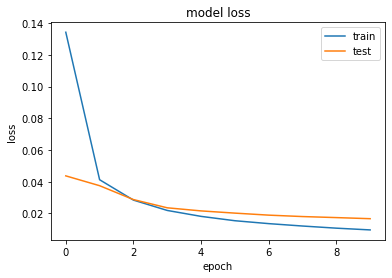

In [11]:
## SOLUTION
def fit_model(num_users, num_courses, x_train, y_train, x_val, y_val):

    print(f"Training shape {x_train.shape}, {y_train.shape}")
    embedding_size = 16
    model = RecommenderNet(num_users, num_courses, embedding_size)
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=64,
        epochs=10,
        verbose=1,
        validation_data=(x_val, y_val),
    )
    #model.save('saved_model/emd_cf')

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper right")
    plt.show()
    return model

model = fit_model(num_users, num_items, x_train, y_train, x_val, y_val)